In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

In [2]:
class ArrayDataset:
    def __init__(self):
        self.file1 = '../input/mnist-data/train-images.idx3-ubyte'
        self.file2 = '../input/mnist-data/train-labels.idx1-ubyte'
        self.file3 = '../input/mnist-data/t10k-images.idx3-ubyte'
        self.file4 = '../input/mnist-data/t10k-labels.idx1-ubyte'

    def _loadImageSet(self, filename):
        binfile = open(filename, 'rb')  # 读取二进制文件
        buffers = binfile.read()

        head = struct.unpack_from('>IIII', buffers, 0)  # 取前4个整数，返回一个元组

        offset = struct.calcsize('>IIII')  # 定位到data开始的位置
        imgNum = head[1]
        width = head[2]
        height = head[3]

        bits = imgNum * width * height  # data一共有60000*28*28个像素值

        bitsString = '>' + str(bits) + 'B'  # fmt格式：'>47040000B'

        imgs = struct.unpack_from(bitsString, buffers, offset)  # 取data数据，返回一个元组

        binfile.close()
        imgs = np.reshape(imgs, [imgNum, width * height])  # reshape为[60000,784]型数组

        return imgs, head

    def _loadLabelSet(self, filename):
        binfile = open(filename, 'rb')  # 读二进制文件
        buffers = binfile.read()

        head = struct.unpack_from('>II', buffers, 0)  # 取label文件前2个整形数

        labelNum = head[1]
        offset = struct.calcsize('>II')  # 定位到label数据开始的位置

        numString = '>' + str(labelNum) + "B"  # fmt格式：'>60000B'
        labels = struct.unpack_from(numString, buffers, offset)  # 取label数据

        binfile.close()
        labels = np.reshape(labels, [labelNum])  # 转型为列表(一维数组)

        return labels, head

    def getTrainSet(self):
        imgs, data_head = self._loadImageSet(self.file1)
        labels, labels_head = self._loadLabelSet(self.file2)
        return imgs, labels

    def getTestSet(self):
        imgs, data_head = self._loadImageSet(self.file3)
        labels, labels_head = self._loadLabelSet(self.file4)
        return imgs, labels



In [3]:
class Dataset:
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        if self.transform is None:
            return self.data[item], self.target[item]
        else:
            return self.transform(self.data[item]), self.target[item]

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1=self.get_conv_block(1,64)
        self.layer2=self.get_conv_block(64,128,paddings=(0,1))
        self.layer3=self.get_conv_block(128,256)
        self.fc1=nn.Linear(256*3*3,2048) # 全连接层
        self.fc2=nn.Linear(2048,512)
        self.fc3=nn.Linear(512,10)
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x).flatten(start_dim=1)
        x=F.dropout(F.relu(self.fc1(x)),0.7,training=self.training)
        out=self.fc3(F.relu(self.fc2(x)))
        return out
    def get_conv_block(self,in_chan,out_chan,strides=(1,1),paddings=(1,1)):
        return nn.Sequential(
            nn.Conv2d(in_chan,out_chan,3,strides[0],paddings[0]), # 卷积层
            nn.ReLU(), # 激活层
            nn.BatchNorm2d(out_chan), # 批归一化
            nn.Conv2d(out_chan,out_chan,3,strides[0],paddings[1]),
            nn.ReLU(),
            nn.BatchNorm2d(out_chan),
            nn.MaxPool2d(2) # 池化层
        )

In [5]:
!nvidia-smi

Fri Apr 16 08:09:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
arrayDataset = ArrayDataset()
train_images, train_labels = arrayDataset.getTrainSet()
test_images, test_labels = arrayDataset.getTestSet()

print(train_images.shape)
print(train_labels.shape)

train_images = train_images.reshape(-1, 28, 28).astype(np.uint8)
test_images = test_images.reshape(-1, 28, 28).astype(np.uint8)
print(train_images.shape)

transform = transforms.Compose([
    transforms.ToPILImage(),  # 转换成图片
    transforms.RandomResizedCrop(size=28, scale=(0.9, 1.0), ratio=(0.9, 1, 15)),  # 随机剪裁
    transforms.RandomAffine(degrees=12, translate=(1 / 7, 1 / 7), shear=12),  # 仿射变换
    transforms.RandomRotation(degrees=12),  # 按角度随机旋转
    transforms.ToTensor(),  # 转换成张量
])

transformToTensor = transforms.Compose([
    transforms.ToTensor(),  # 转换成张量
])

train_set = Dataset(train_images, train_labels, transform)
test_set = Dataset(test_images, test_labels,transformToTensor)

train_loader = DataLoader(train_set, 512, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, 512, shuffle=False, pin_memory=True)

(60000, 784)
(60000,)
(60000, 28, 28)


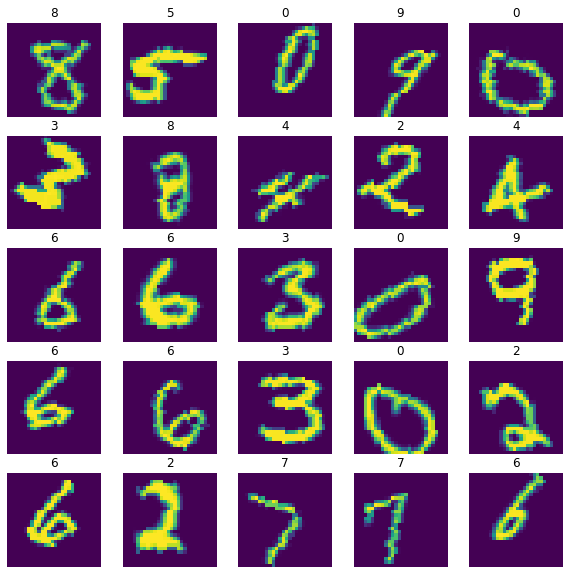

In [7]:
x, y = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1).axis('off')
    plt.imshow(x[i].squeeze(0))
    plt.title(str(y[i].item()))
plt.show()

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [9]:
net = Net()
print(net)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(

In [10]:
acc_list=[]
loss_list=[]
num_list=[]

In [11]:
epochs = 50

loss_fun = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=1e-4)

net.to(device)
for i in range(epochs):
    net = net.train()
    with tqdm(train_loader, desc=f"{i + 1}/{epochs} epochs") as t:
        running_correct = 0.0
        running_loss = 0.0
        running_total = 0.0
        for x, y in t:
            out = net(x.to(device))
            y = y.to(device)
            pred = out.max(dim=1)[1]
            loss = loss_fun(out, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
            running_correct += (pred == y).sum().item()
            running_total += x.size(0)
            acc_value=running_correct / running_total
            loss_value=running_loss / running_total
            acc_list.append(acc_value)
            loss_list.append(loss_value)
            num_list.append(running_total)
            t.set_postfix({"train_acc": acc_value, "train_loss": loss_value})

50/50 epochs: 100%|██████████| 118/118 [00:29<00:00,  4.05it/s, train_acc=0.995, train_loss=0.0154]


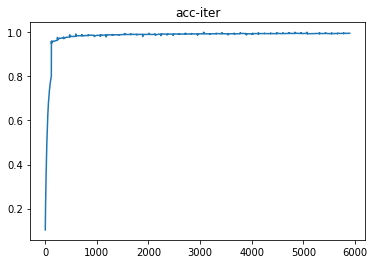

In [37]:
plt.plot(acc_list)
plt.title("acc-iter")
plt.savefig('acc-iter.png')
plt.show()

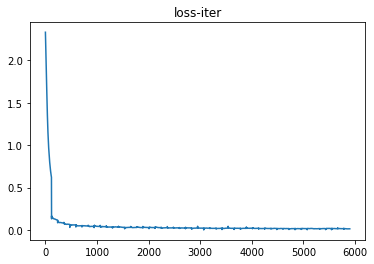

In [38]:
plt.plot(loss_list)
plt.title("loss-iter")
plt.savefig('loss-iter.png')
plt.show()

In [14]:
# 卷积神经网络版
net.eval()
acc_num=0
preds=[]
results=[]
n=0
with torch.no_grad():
    with tqdm(test_loader, desc=f"The model is evaluating ...") as t:
        for x, y in t:
            out = net(x.to(device))
            pred = out.max(dim=1)[1]
            preds.append(pred)
            results.append(y)
            t.set_postfix()
for i in range(len(preds)):
    for j in range(len(preds[i])):
        if preds[i][j]==results[i][j]:
            acc_num+=1
        n+=1
print("acc:",acc_num/n)

The model is evaluating ...: 100%|██████████| 20/20 [00:00<00:00, 55.62it/s]


acc: 0.9959


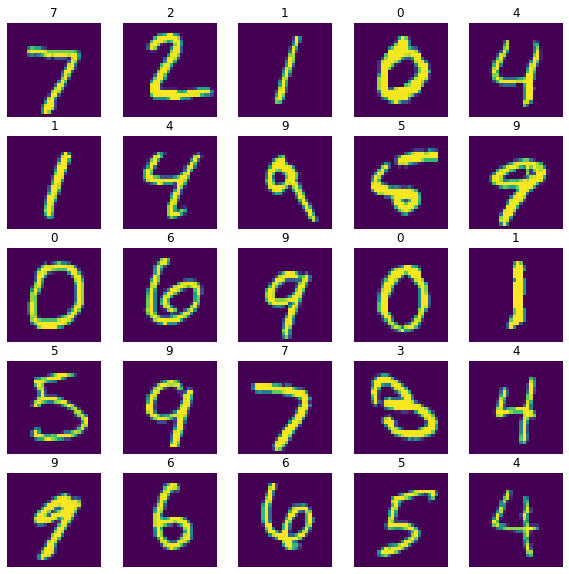

In [16]:
# 卷积神经网络版
x, _ = next(iter(test_loader))
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1).axis('off')
    plt.imshow(x[i].squeeze(0))
    plt.title(preds[0][i].cpu().numpy())
plt.show()